# CMSC 472 Final Project: 
# Monocular Visual Odometry using Dense Prediction Transformers


### Data loader and Preprocessing

This project uses KITTI Visual Odometry Dataset, which can be found at http://www.cvlibs.net/datasets/kitti/eval_odometry.php

In [33]:
# !pip install einops
# !pip install timm
# !pip install wandb

### Download Custom Depth dataset, NYUv2, inria and posetrack

Run below 2 cells only for the first time

In [34]:
# !gdown 1wbDWkn4uyYUe3hGPYoXWQN_MMvGCda-R

In [35]:
# !unzip "/content/depth_dataset.zip"

In [36]:
import glob
import os, errno
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import timm
import wandb
from numpy.core.numeric import Inf
import glob as glob_module
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from torchvision import transforms, utils
import random
from glob import glob
from tqdm import tqdm
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import json
from torch.utils.data import ConcatDataset
from sklearn import linear_model
from torchvision import transforms
from scipy.ndimage.filters import gaussian_filter


/tmp/ipykernel_140811/2955035506.py:30: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [37]:
class KITTI:
    def __init__(self,
                 data_path=r"/dataset/sequences",
                 pose_path=r"dataset/poses",
                 sequence="00",
                 camera_id="0",
                 ):
        """
        Dataloader for KITTI Visual Odometry Dataset
            http://www.cvlibs.net/datasets/kitti/eval_odometry.php

        Arguments:
            data_path {str}: path to data sequences
            pose_path {str}: path to poses
            sequence {str}: sequence to be tested (default: "00")
        """
        self.data_path = data_path
        self.sequence = sequence
        self.camera_id = camera_id
        self.frame_id = 0

        # Read ground truth poses
        with open(os.path.join(pose_path, sequence+".txt")) as f:
            self.poses = f.readlines()

        # Get frames list
        frames_dir = os.path.join(data_path, sequence, "image_{}".format(camera_id), "*.png")
        print(frames_dir)
        self.frames = sorted(glob_module.glob(frames_dir))

        # Camera Parameters
        self.cam_params = {}
        frame = cv2.imread(self.frames[self.frame_id], 0)
        self.cam_params["width"] = frame.shape[0]
        self.cam_params["height"] = frame.shape[1]
        self.read_intrinsics_param()

    def __len__(self):
        return len(self.frames)

    def get_next_data(self):
        """
        Returns:
            frame {ndarray}: image frame at index self.frame_id
            pose {list}: list containing the ground truth pose [x, y, z]
            frame_id {int}: integer representing the frame index
        """
        # Read frame as grayscale
        frame = cv2.imread(self.frames[self.frame_id], 0)
        self.cam_params["width"] = frame.shape[0]
        self.cam_params["height"] = frame.shape[0]

        # Read poses
        pose = self.poses[self.frame_id]
        pose = pose.strip().split()
        pose = [float(pose[3]), float(pose[7]), float(pose[11])]  # coordinates for the left camera
        frame_id = self.frame_id
        self.frame_id = self.frame_id + 1
        return frame, pose, frame_id


    def read_intrinsics_param(self):
        """
        Reads camera intrinsics parameters

        Returns:
            cam_params {dict}: dictionary with focal lenght and principal point
        """
        calib_file = os.path.join(self.data_path, self.sequence, "calib.txt")
        with open(calib_file, 'r') as f:
            lines = f.readlines()
            line = lines[int(self.camera_id)].strip().split()
            [fx, cx, fy, cy] = [float(line[1]), float(line[3]), float(line[6]), float(line[7])]

            # focal length of camera
            self.cam_params["fx"] = fx
            self.cam_params["fy"] = fy
            # principal point (optical center)
            self.cam_params["cx"] = cx
            self.cam_params["cy"] = cy

In [38]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu').float())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

class DepthDataset(Dataset):
    """
        Dataset class for the Depth Task. Requires for each image, its depth ground-truth and
        segmentation mask
        Args:
            :- config -: json config file
            :- dataset_name -: str
            :- split -: split ['train', 'val', 'test']
    """
    def __init__(self, config, dataset_name, split=None):
        self.split = split
        self.config = config

        path_images = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'])
        path_depths = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'])

        self.paths_images = get_total_paths(path_images, config['Dataset']['extensions']['ext_images'])
        self.paths_depths = get_total_paths(path_depths, config['Dataset']['extensions']['ext_depths'])
        
        assert (self.split in ['train', 'test', 'val']), "Invalid split!"
        assert (len(self.paths_images) == len(self.paths_depths)), "Different number of instances between the input and the depth maps"
        assert (config['Dataset']['splits']['split_train'] + config['Dataset']['splits']['split_test'] + config['Dataset']['splits']['split_val'] == 1), "Invalid splits (sum must be equal to 1)"

        # utility func for splitting
        self.paths_images, self.paths_depths = get_splitted_dataset(config, self.split, dataset_name, self.paths_images, self.paths_depths)

        # Get the transforms
        self.transform_image, self.transform_depth = get_transforms(config)

        # get p_flip from config
        self.p_flip = config['Dataset']['transforms']['p_flip'] if split=='train' else 0
        self.p_crop = config['Dataset']['transforms']['p_crop'] if split=='train' else 0
        self.p_rot = config['Dataset']['transforms']['p_rot'] if split=='train' else 0
        self.resize = config['Dataset']['transforms']['resize']

    def __len__(self):
        """
            Function to get the number of images using the given list of images
        """
        return len(self.paths_images)

    def __getitem__(self, idx):
        """
            Getter function in order to get the triplet of images / depth maps and segmentation masks
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.transform_image(Image.open(self.paths_images[idx]))
        depth = self.transform_depth(Image.open(self.paths_depths[idx]))
        imgorig = image.clone()

        if random.random() < self.p_flip:
            image = TF.hflip(image)
            depth = TF.hflip(depth)

        if random.random() < self.p_crop:
            random_size = random.randint(256, self.resize-1)
            max_size = self.resize - random_size
            left = int(random.random()*max_size)
            top = int(random.random()*max_size)
            image = TF.crop(image, top, left, random_size, random_size)
            depth = TF.crop(depth, top, left, random_size, random_size)
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)

        if random.random() < self.p_rot:
            #rotate
            random_angle = random.random()*20 - 10 #[-10 ; 10]
            mask = torch.ones((1,self.resize,self.resize)) #useful for the resize at the end
            mask = TF.rotate(mask, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            image = TF.rotate(image, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            depth = TF.rotate(depth, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            #crop to remove black borders due to the rotation
            left = torch.argmax(mask[:,0,:]).item()
            top = torch.argmax(mask[:,:,0]).item()
            coin = min(left,top)
            size = self.resize - 2*coin
            image = TF.crop(image, coin, coin, size, size)
            depth = TF.crop(depth, coin, coin, size, size)
            #Resize
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)
        # exit(0)
        return image, depth


### Camera Model setup

In [39]:
class CameraModel(object):
    """
    Class that represents a pin-hole camera model (or projective camera model).
    In the pin-hole camera model, light goes through the camera center (cx, cy) before its projection
    onto the image plane.
    """
    def __init__(self, params):
        """
        Creates a camera model

        Arguments:
            params {dict} -- Camera parameters
        """

        # Image resolution
        self.width = params['width']
        self.height = params['height']
        # Focal length of camera
        self.fx = params['fx']
        self.fy = params['fy']
        # Optical center (principal point)
        self.cx = params['cx']
        self.cy = params['cy']
        # Distortion coefficients.
        # k1, k2, and k3 are the radial coefficients.
        # p1 and p2 are the tangential distortion coefficients.
        #self.distortion_coeff = [params['k1'], params['k2'], params['p1'], params['p2'], params['k3']]
        self.mat = np.array([
                [self.fx, 0, self.cx],
                [0, self.fy, self.cy],
                [0, 0, 1]])

### Dense Estimation model using visual transformers

#### Depth Estimation Transformer Model Architecture

In [40]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode, align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        x = self.interp(
            x,
            scale_factor=self.scale_factor,
            mode=self.mode,
            align_corners=self.align_corners)
        return x

class HeadDepth(nn.Module):
    def __init__(self, features):
        super(HeadDepth, self).__init__()
        self.head = nn.Sequential(
            nn.Conv2d(features, features // 2, kernel_size=3, stride=1, padding=1),
            Interpolate(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(features // 2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            # nn.ReLU()
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.head(x)
        # x = (x - x.min())/(x.max()-x.min() + 1e-15)
        return x


In [41]:
class ResidualConvUnit(nn.Module):
    def __init__(self, features):
        super().__init__()

        self.conv1 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """Forward pass.
        Args:
            x (tensor): input
        Returns:
            tensor: output
        """
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        return out + x

class Fusion(nn.Module):
    def __init__(self, resample_dim):
        super(Fusion, self).__init__()
        self.res_conv1 = ResidualConvUnit(resample_dim)
        self.res_conv2 = ResidualConvUnit(resample_dim)
        #self.resample = nn.ConvTranspose2d(resample_dim, resample_dim, kernel_size=2, stride=2, padding=0, bias=True, dilation=1, groups=1)

    def forward(self, x, previous_stage=None):
        if previous_stage == None:
            previous_stage = torch.zeros_like(x)
        output_stage1 = self.res_conv1(x)
        output_stage1 += previous_stage
        output_stage2 = self.res_conv2(output_stage1)
        output_stage2 = nn.functional.interpolate(output_stage2, scale_factor=2, mode="bilinear", align_corners=True)
        return output_stage2


In [42]:
class Read_ignore(nn.Module):
    def __init__(self, start_index=1):
        super(Read_ignore, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        return x[:, self.start_index:]


class Read_add(nn.Module):
    def __init__(self, start_index=1):
        super(Read_add, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        if self.start_index == 2:
            readout = (x[:, 0] + x[:, 1]) / 2
        else:
            readout = x[:, 0]
        return x[:, self.start_index :] + readout.unsqueeze(1)


class Read_projection(nn.Module):
    def __init__(self, in_features, start_index=1):
        super(Read_projection, self).__init__()
        self.start_index = start_index
        self.project = nn.Sequential(nn.Linear(2 * in_features, in_features), nn.GELU())

    def forward(self, x):
        readout = x[:, 0].unsqueeze(1).expand_as(x[:, self.start_index :])
        features = torch.cat((x[:, self.start_index :], readout), -1)
        return self.project(features)

class MyConvTranspose2d(nn.Module):
    def __init__(self, conv, output_size):
        super(MyConvTranspose2d, self).__init__()
        self.output_size = output_size
        self.conv = conv

    def forward(self, x):
        x = self.conv(x, output_size=self.output_size)
        return x

class Resample(nn.Module):
    def __init__(self, p, s, h, emb_dim, resample_dim):
        super(Resample, self).__init__()
        assert (s in [4, 8, 16, 32]), "s must be in [0.5, 4, 8, 16, 32]"
        self.conv1 = nn.Conv2d(emb_dim, resample_dim, kernel_size=1, stride=1, padding=0)
        if s == 4:
            self.conv2 = nn.ConvTranspose2d(resample_dim,
                                resample_dim,
                                kernel_size=4,
                                stride=4,
                                padding=0,
                                bias=True,
                                dilation=1,
                                groups=1)
        elif s == 8:
            self.conv2 = nn.ConvTranspose2d(resample_dim,
                                resample_dim,
                                kernel_size=2,
                                stride=2,
                                padding=0,
                                bias=True,
                                dilation=1,
                                groups=1)
        elif s == 16:
            self.conv2 = nn.Identity()
        else:
            self.conv2 = nn.Conv2d(resample_dim, resample_dim, kernel_size=2,stride=2, padding=0, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class Reassemble(nn.Module):
    def __init__(self, image_size, read, p, s, emb_dim, resample_dim):
        """
        p = patch size
        s = coefficient resample
        emb_dim <=> D (in the paper)
        resample_dim <=> ^D (in the paper)
        read : {"ignore", "add", "projection"}
        """
        super(Reassemble, self).__init__()
        channels, image_height, image_width = image_size

        #Read
        self.read = Read_ignore()
        if read == 'add':
            self.read = Read_add()
        elif read == 'projection':
            self.read = Read_projection(emb_dim)

        #Concat after read
        self.concat = Rearrange('b (h w) c -> b c h w',
                                c=emb_dim,
                                h=(image_height // p),
                                w=(image_width // p))

        #Projection + Resample
        self.resample = Resample(p, s, image_height, emb_dim, resample_dim)

    def forward(self, x):
        x = self.read(x)
        x = self.concat(x)
        x = self.resample(x)
        return x


In [43]:
torch.manual_seed(0)

class DepthTransformerModel(nn.Module):
    def __init__(self,
                 image_size         = (3, 384, 384),
                 patch_size         = 16,
                 emb_dim            = 1024,
                 resample_dim       = 256,
                 read               = 'projection',
                 num_layers_encoder = 24,
                 hooks              = [5, 11, 17, 23],
                 reassemble_s       = [4, 8, 16, 32],
                 transformer_dropout= 0,
                 nclasses           = 2,
                 type               = "depth",
                 model_timm         = "vit_large_patch16_384"):
        """
        Depth Transformer Model
        type : {"depth"}
        image_size : (c, h, w)
        patch_size : *a square*
        emb_dim <=> D (in the paper)
        resample_dim <=> ^D (in the paper)
        read : {"ignore", "add", "projection"}
        """
        super().__init__()

        self.transformer_encoders = timm.create_model(model_timm, pretrained=True)
        self.type_ = type

        #Register hooks
        self.activation = {}
        self.hooks = hooks
        self._get_layers_from_hooks(self.hooks)

        #Reassembles Fusion
        self.reassembles = []
        self.fusions = []
        for s in reassemble_s:
            self.reassembles.append(Reassemble(image_size, read, patch_size, s, emb_dim, resample_dim))
            self.fusions.append(Fusion(resample_dim))
        self.reassembles = nn.ModuleList(self.reassembles)
        self.fusions = nn.ModuleList(self.fusions)

        #Head
        if type == "depth":
            self.head_depth = HeadDepth(resample_dim)

    def forward(self, img):

        t = self.transformer_encoders(img)
        previous_stage = None
        for i in np.arange(len(self.fusions)-1, -1, -1):
            hook_to_take = 't'+str(self.hooks[i])
            activation_result = self.activation[hook_to_take]
            reassemble_result = self.reassembles[i](activation_result)
            fusion_result = self.fusions[i](reassemble_result, previous_stage)
            previous_stage = fusion_result
        out_depth = None
        if self.head_depth != None:
            out_depth = self.head_depth(previous_stage)
        return out_depth

    def _get_layers_from_hooks(self, hooks):
        def get_activation(name):
            def hook(model, input, output):
                self.activation[name] = output
            return hook
        for h in hooks:
            self.transformer_encoders.blocks[h].register_forward_hook(get_activation('t'+str(h)))

In [44]:

def get_total_paths(path, ext):
    return glob(os.path.join(path, '*'+ext))

def get_splitted_dataset(config, split, dataset_name, path_images, path_depths):
    list_files = [os.path.basename(im) for im in path_images]
    np.random.seed(config['General']['seed'])
    np.random.shuffle(list_files)
    if split == 'train':
        selected_files = list_files[:int(len(list_files)*config['Dataset']['splits']['split_train'])]
    elif split == 'val':
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train']):int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val'])]
    else:
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val']):]

    path_images = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'], im[:-4]+config['Dataset']['extensions']['ext_images']) for im in selected_files]
    path_depths = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'], im[:-4]+config['Dataset']['extensions']['ext_depths']) for im in selected_files]
    # path_segmentation = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_segmentations'], im[:-4]+config['Dataset']['extensions']['ext_segmentations']) for im in selected_files]
    return path_images, path_depths

def get_transforms(config):
    im_size = config['Dataset']['transforms']['resize']
    transform_image = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_depth = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.Grayscale(num_output_channels=1) ,
        transforms.ToTensor()
    ])
    return transform_image, transform_depth

def get_losses(config):
    def NoneFunction(a, b):
        return 0
    loss_depth = NoneFunction
    type = config['General']['type']
    if type=="depth":
        if config['General']['loss_depth'] == 'mse':
            loss_depth = nn.MSELoss()
        elif config['General']['loss_depth'] == 'ssi':
            loss_depth = ScaleAndShiftInvariantLoss()
    return loss_depth

def create_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def get_optimizer(config, net):
    names = set([name.split('.')[0] for name, _ in net.named_modules()]) - set(['', 'transformer_encoders'])
    params_backbone = net.transformer_encoders.parameters()
    params_scratch = list()
    for name in names:
        params_scratch += list(eval("net."+name).parameters())

    if config['General']['optim'] == 'adam':
        optimizer_backbone = optim.Adam(params_backbone, lr=config['General']['lr_backbone'])
        optimizer_scratch = optim.Adam(params_scratch, lr=config['General']['lr_scratch'])
    elif config['General']['optim'] == 'sgd':
        optimizer_backbone = optim.SGD(params_backbone, lr=config['General']['lr_backbone'], momentum=config['General']['momentum'])
        optimizer_scratch = optim.SGD(params_scratch, lr=config['General']['lr_scratch'], momentum=config['General']['momentum'])
    return optimizer_backbone, optimizer_scratch

def get_schedulers(optimizers):
    return [ReduceLROnPlateau(optimizer) for optimizer in optimizers]


In [45]:
def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


def reduction_batch_based(image_loss, M):
    # average of all valid pixels of the batch

    # avoid division by 0 (if sum(M) = sum(sum(mask)) = 0: sum(image_loss) = 0)
    divisor = torch.sum(M)

    if divisor == 0:
        return 0
    else:
        return torch.sum(image_loss) / divisor


def reduction_image_based(image_loss, M):
    # mean of average of valid pixels of an image

    # avoid division by 0 (if M = sum(mask) = 0: image_loss = 0)
    valid = M.nonzero()

    image_loss[valid] = image_loss[valid] / M[valid]

    return torch.mean(image_loss)


def mse_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))
    res = prediction - target
    image_loss = torch.sum(mask * res * res, (1, 2))

    return reduction(image_loss, 2 * M)


def gradient_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))

    diff = prediction - target
    diff = torch.mul(mask, diff)

    grad_x = torch.abs(diff[:, :, 1:] - diff[:, :, :-1])
    mask_x = torch.mul(mask[:, :, 1:], mask[:, :, :-1])
    grad_x = torch.mul(mask_x, grad_x)

    grad_y = torch.abs(diff[:, 1:, :] - diff[:, :-1, :])
    mask_y = torch.mul(mask[:, 1:, :], mask[:, :-1, :])
    grad_y = torch.mul(mask_y, grad_y)

    image_loss = torch.sum(grad_x, (1, 2)) + torch.sum(grad_y, (1, 2))

    return reduction(image_loss, M)


class MSELoss(nn.Module):
    def __init__(self, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

    def forward(self, prediction, target, mask):
        return mse_loss(prediction, target, mask, reduction=self.__reduction)


class GradientLoss(nn.Module):
    def __init__(self, scales=4, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

        self.__scales = scales

    def forward(self, prediction, target, mask):
        total = 0

        for scale in range(self.__scales):
            step = pow(2, scale)

            total += gradient_loss(prediction[:, ::step, ::step], target[:, ::step, ::step],
                                   mask[:, ::step, ::step], reduction=self.__reduction)

        return total


class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self, alpha=0.5, scales=4, reduction='batch-based'):
        super().__init__()

        self.__data_loss = MSELoss(reduction=reduction)
        self.__regularization_loss = GradientLoss(scales=scales, reduction=reduction)
        self.__alpha = alpha

        self.__prediction_ssi = None

    def forward(self, prediction, target):
        #preprocessing
        mask = target > 0

        #calcul
        scale, shift = compute_scale_and_shift(prediction, target, mask)
        # print(scale, shift)
        self.__prediction_ssi = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        total = self.__data_loss(self.__prediction_ssi, target, mask)
        if self.__alpha > 0:
            total += self.__alpha * self.__regularization_loss(self.__prediction_ssi, target, mask)

        return total

    def __get_prediction_ssi(self):
        return self.__prediction_ssi

    prediction_ssi = property(__get_prediction_ssi)


In [85]:


class Predictor(object):
    def __init__(self, config, input_images, frame):
        self.input_images = input_images
        self.config = config
        self.type = self.config['General']['type']
        self.frame = frame

        self.device = torch.device(self.config['General']['device'] if torch.cuda.is_available() else "cpu")
        print("device: %s" % self.device)
        resize = config['Dataset']['transforms']['resize']
        self.model = DepthTransformerModel(
                    image_size  =   (3,resize,resize),
                    emb_dim     =   config['General']['emb_dim'],
                    resample_dim=   config['General']['resample_dim'],
                    read        =   config['General']['read'],
                    nclasses    =   len(config['Dataset']['classes']) + 1,
                    hooks       =   config['General']['hooks'],
                    model_timm  =   config['General']['model_timm'],
                    type        =   self.type,
                    patch_size  =   config['General']['patch_size'],
        )
        # path_model = os.path.join(config['General']['path_model'], 'DepthTransformerModel_{}.p'.format(config['General']['model_timm']))
        path_model = os.path.join('models/FocusOnDepth_vit_base_patch16_384.p')
        self.model.load_state_dict(
            torch.load(path_model, map_location=self.device)['model_state_dict'], strict=False
        )
        self.model.eval()
        self.transform_image = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.output_dir = self.config['General']['path_predicted_images']
        create_dir(self.output_dir)

    def run(self):
        with torch.no_grad():
            for images in self.input_images:
                pil_im = Image.open(images).convert("RGB")
                original_size = pil_im.size
                tensor_im = self.transform_image(pil_im).unsqueeze(0)
                output_depth = self.model(tensor_im)
                output_depth = 1-output_depth
                output_depth = transforms.ToPILImage()(output_depth.squeeze(0).float()).resize(original_size, resample=Image.BICUBIC)
                path_dir_depths = os.path.join(self.output_dir, 'depths')
                create_dir(path_dir_depths)
                output_depth.save(os.path.join(path_dir_depths, os.path.basename(images)))

    def get_depth(self):
        with torch.no_grad():
            # Convert the NumPy array to a PIL Image
            # Convert the single-channel image to a 3-channel image by duplicating the channels
            three_channel_frame = np.stack((self.frame,) * 3, axis=-1)
            pil_frame = Image.fromarray(three_channel_frame)

            
            # Get the original size of the frame
            original_size = pil_frame.size
            
            # Transform the frame and get the depth and segmentation output
            tensor_im = self.transform_image(pil_frame).unsqueeze(0)
            output_depth = self.model(tensor_im)
            output_depth = 1 - output_depth
            
            # Convert the output depth tensor back to a PIL Image and resize it to the original size
            output_depth = transforms.ToPILImage()(output_depth.squeeze(0).float()).resize(original_size, resample=Image.BICUBIC)
            return output_depth



#### Train the Depth Estimation Transformer Model

In [47]:
class Trainer(object):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.type = self.config['General']['type']

        self.device = torch.device(self.config['General']['device'] if torch.cuda.is_available() else "cpu")
        print("device: %s" % self.device)
        resize = config['Dataset']['transforms']['resize']
        self.model = DepthTransformerModel(
                    image_size  =   (3,resize,resize),
                    emb_dim     =   config['General']['emb_dim'],
                    resample_dim=   config['General']['resample_dim'],
                    read        =   config['General']['read'],
                    nclasses    =   len(config['Dataset']['classes']) + 1,
                    hooks       =   config['General']['hooks'],
                    model_timm  =   config['General']['model_timm'],
                    type        =   self.type,
                    patch_size  =   config['General']['patch_size'],
        )

        self.model.to(self.device)
        # print(self.model)
        # exit(0)

        self.loss_depth = get_losses(config)
        self.optimizer_backbone, self.optimizer_scratch = get_optimizer(config, self.model)
        self.schedulers = get_schedulers([self.optimizer_backbone, self.optimizer_scratch])

    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['General']['epochs']
        val_loss = Inf
        for epoch in range(epochs):  # loop over the dataset multiple times
            print("Epoch ", epoch+1)
            running_loss = 0.0
            self.model.train()
            pbar = tqdm(train_dataloader)
            pbar.set_description("Training")
            for i, (X, Y_depths) in enumerate(pbar):
                # get the inputs; data is a list of [inputs, labels]
                X, Y_depths = X.to(self.device), Y_depths.to(self.device)
                # zero the parameter gradients
                self.optimizer_backbone.zero_grad()
                self.optimizer_scratch.zero_grad()
                # forward + backward + optimizer
                output_depths = self.model(X)
                output_depths = output_depths.squeeze(1) if output_depths != None else None

                Y_depths = Y_depths.squeeze(1) #1xHxW -> HxW
                # Y_segmentations = Y_segmentations.squeeze(1) #1xHxW -> HxW
                # get loss
                loss = self.loss_depth(output_depths, Y_depths)
                loss.backward()
                # step optimizer
                self.optimizer_scratch.step()
                self.optimizer_backbone.step()

                running_loss += loss.item()
                if np.isnan(running_loss):
                    print('\n',
                        X.min().item(), X.max().item(),'\n',
                        Y_depths.min().item(), Y_depths.max().item(),'\n',
                        output_depths.min().item(), output_depths.max().item(),'\n',
                        loss.item(),
                    )
                    exit(0)

                pbar.set_postfix({'training_loss': running_loss/(i+1)})

            new_val_loss = self.run_eval(val_dataloader)

            if new_val_loss < val_loss:
                self.save_model()
                val_loss = new_val_loss

            self.schedulers[0].step(new_val_loss)
            self.schedulers[1].step(new_val_loss)

        print('Finished Training')

    def run_eval(self, val_dataloader):
        """
            Evaluate the model on the validation set and visualize some results
            on wandb
            :- val_dataloader -: torch dataloader
        """
        val_loss = 0.
        self.model.eval()
        X_1 = None
        Y_depths_1 = None
        Y_segmentations_1 = None
        output_depths_1 = None
        output_segmentations_1 = None
        with torch.no_grad():
            pbar = tqdm(val_dataloader)
            pbar.set_description("Validation")
            for i, (X, Y_depths) in enumerate(pbar):
                X, Y_depths= X.to(self.device), Y_depths.to(self.device)
                output_depths = self.model(X)
                output_depths = output_depths.squeeze(1) if output_depths != None else None
                Y_depths = Y_depths.squeeze(1)
                if i==0:
                    X_1 = X
                    Y_depths_1 = Y_depths
                    output_depths_1 = output_depths
                # get loss
                loss = self.loss_depth(output_depths, Y_depths)
                val_loss += loss.item()
                pbar.set_postfix({'validation_loss': val_loss/(i+1)})

        return val_loss/(i+1)

    def save_model(self):
        path_model = os.path.join(self.config['General']['path_model'], self.model.__class__.__name__)
        create_dir(path_model)
        torch.save({'model_state_dict': self.model.state_dict(),
                    'optimizer_backbone_state_dict': self.optimizer_backbone.state_dict(),
                    'optimizer_scratch_state_dict': self.optimizer_scratch.state_dict()
                    }, path_model+'.p')
        print('Model saved at : {}'.format(path_model))


#### Run Train

In [48]:
with open('config.json', 'r') as f:
    config = json.load(f)
np.random.seed(config['General']['seed'])

list_data = config['Dataset']['paths']['list_datasets']

## train set
depth_datasets_train = []
for dataset_name in list_data:
    depth_datasets_train.append(DepthDataset(config, dataset_name, 'train'))

train_data = ConcatDataset(depth_datasets_train)
train_dataloader = DataLoader(train_data, batch_size=config['General']['batch_size'], shuffle=True)
## validation set
depth_datasets_val = []
for dataset_name in list_data:
    depth_datasets_val.append(DepthDataset(config, dataset_name, 'val'))
val_data = ConcatDataset(depth_datasets_val)
val_dataloader = DataLoader(val_data, batch_size=config['General']['batch_size'], shuffle=True)

trainer = Trainer(config)
trainer.train(train_dataloader, val_dataloader)

device: cuda
Epoch  1


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.31it/s, validation_loss=0.0132]


Model saved at : models/DepthTransformerModel
Epoch  2


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.30it/s, validation_loss=0.011] 


Model saved at : models/DepthTransformerModel
Epoch  3


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.34it/s, validation_loss=0.00949]


Model saved at : models/DepthTransformerModel
Epoch  4


Validation: 100%|██████████| 793/793 [00:39<00:00, 20.22it/s, validation_loss=0.00968]


Epoch  5


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.32it/s, validation_loss=0.00963]


Epoch  6


Validation: 100%|██████████| 793/793 [00:41<00:00, 18.99it/s, validation_loss=0.00914]


Model saved at : models/DepthTransformerModel
Epoch  7


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.20it/s, validation_loss=0.00834]


Model saved at : models/DepthTransformerModel
Epoch  8


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.18it/s, validation_loss=0.00772]


Model saved at : models/DepthTransformerModel
Epoch  9


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.50it/s, validation_loss=0.00791]


Epoch  10


Validation: 100%|██████████| 793/793 [00:41<00:00, 19.03it/s, validation_loss=0.00754]


Model saved at : models/DepthTransformerModel
Epoch  11


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.46it/s, validation_loss=0.00771]


Epoch  12


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.56it/s, validation_loss=0.00767]


Epoch  13


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.62it/s, validation_loss=0.00728]


Model saved at : models/DepthTransformerModel
Epoch  14


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.55it/s, validation_loss=0.00752]


Epoch  15


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.52it/s, validation_loss=0.00785]


Epoch  16


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.59it/s, validation_loss=0.00716]


Model saved at : models/DepthTransformerModel
Epoch  17


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.54it/s, validation_loss=0.00696]


Model saved at : models/DepthTransformerModel
Epoch  18


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.56it/s, validation_loss=0.00717]


Epoch  19


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.61it/s, validation_loss=0.00713]


Epoch  20


Validation: 100%|██████████| 793/793 [00:40<00:00, 19.61it/s, validation_loss=0.00699]

Finished Training


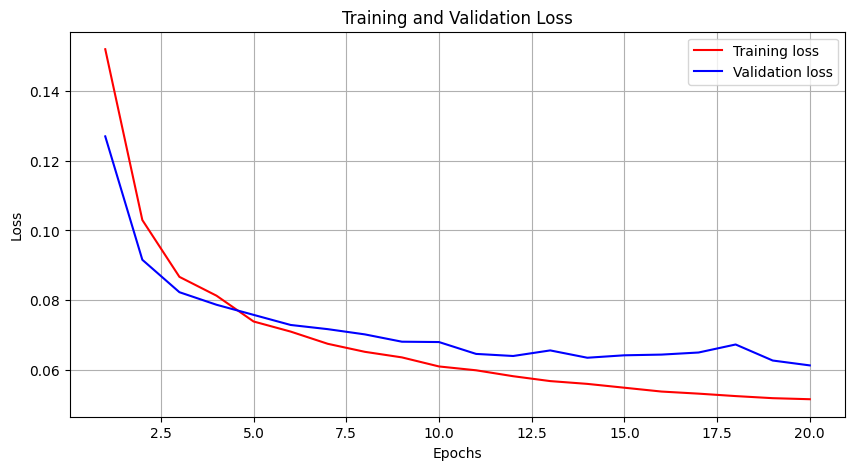

In [60]:
training_loss = []
validation_loss = []
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Run Inferance on the Depth Estimation Model

In [62]:
with open('config.json', 'r') as f:
    config = json.load(f)

input_images = glob('input/*.jpg') + glob('input/*.png')
predictor = Predictor(config, input_images, frame=None)
predictor.run()


device: cuda


#### Plot Predicted Dense Map

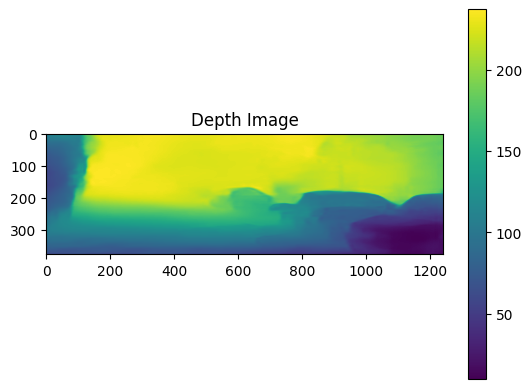

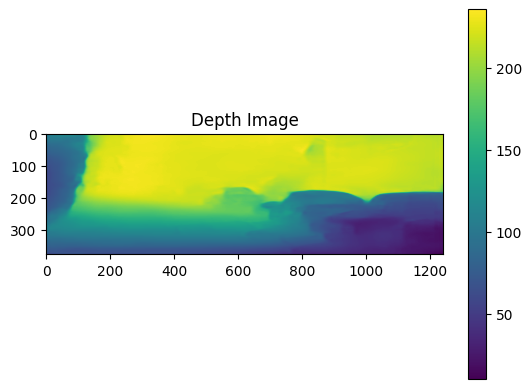

In [75]:
def plot_depth(depth_image_path):
    # Check if the file exists
    if not os.path.exists(depth_image_path):
        print(f"File not found: {depth_image_path}")
        return

    # Open the depth image using PIL
    depth_image = Image.open(depth_image_path)

    # Plot the depth image using matplotlib
    plt.imshow(depth_image, cmap='viridis')
    plt.colorbar()
    plt.title('Depth Image')
    plt.show()

# Define the directory path
directory_path = "output/depths"

# Get all .png files in the directory
image_paths = glob(os.path.join(directory_path, "*.png"))

# Loop through all image paths and plot each image
for image_path in image_paths:
    plot_depth(image_path)

### Monocular Visual Odometry

In [52]:
''''''
'''
@Author: Huangying Zhan (huangying.zhan.work@gmail.com)
@Date: 2020-03-01
@Copyright: Copyright (C) Huangying Zhan 2020. All rights reserved. Please refer to the license file.
@LastEditTime: 2020-05-27
@LastEditors: Huangying Zhan
@Description: This file contains functions related to GRIC computation
'''

def compute_fundamental_residual(F, kp1, kp2):
    """
    Compute fundamental matrix residual

    Args:
        F (array, [3x3]): Fundamental matrix (from view-1 to view-2)
        kp1 (array, [Nx2]): keypoint 1
        kp2 (array, [Nx2]): keypoint 2

    Returns:
        res (array, [N]): residual
    """
    # get homogeneous keypoints (3xN array)
    m0 = np.ones((3, kp1.shape[0]))
    m0[:2] = np.transpose(kp1, (1, 0))
    m1 = np.ones((3, kp2.shape[0]))
    m1[:2] = np.transpose(kp2, (1, 0))

    Fm0 = F @ m0  # 3xN
    Ftm1 = F.T @ m1  # 3xN

    m1Fm0 = (np.transpose(Fm0, (1, 0)) @ m1).diagonal()
    res = m1Fm0 ** 2 / (np.sum(Fm0[:2] ** 2, axis=0) + np.sum(Ftm1[:2] ** 2, axis=0))
    return res


def compute_homography_residual(H_in, kp1, kp2):
    """
    Compute homography matrix residual

    Args:
        H (array, [3x3]): homography matrix (Transformation from view-1 to view-2)
        kp1 (array, [Nx2]): keypoint 1
        kp2 (array, [Nx2]): keypoint 2

    Returns:
        res (array, [N]): residual
    """
    n = kp1.shape[0]
    H = H_in.flatten()

    # get homogeneous keypoints (3xN array)
    m0 = np.ones((3, kp1.shape[0]))
    m0[:2] = np.transpose(kp1, (1, 0))
    m1 = np.ones((3, kp2.shape[0]))
    m1[:2] = np.transpose(kp2, (1, 0))

    G0 = np.zeros((3, n))
    G1 = np.zeros((3, n))

    G0[0] = H[0] - m1[0] * H[6]
    G0[1] = H[1] - m1[0] * H[7]
    G0[2] = -m0[0] * H[6] - m0[1] * H[7] - H[8]

    G1[0] = H[3] - m1[1] * H[6]
    G1[1] = H[4] - m1[1] * H[7]
    G1[2] = -m0[0] * H[6] - m0[1] * H[7] - H[8]

    magG0 = np.sqrt(G0[0] * G0[0] + G0[1] * G0[1] + G0[2] * G0[2])
    magG1 = np.sqrt(G1[0] * G1[0] + G1[1] * G1[1] + G1[2] * G1[2])
    magG0G1 = G0[0] * G1[0] + G0[1] * G1[1]

    alpha = np.arccos(magG0G1 / (magG0 * magG1))

    alg = np.zeros((2, n))
    alg[0] = m0[0] * H[0] + m0[1] * H[1] + H[2] - \
             m1[0] * (m0[0] * H[6] + m0[1] * H[7] + H[8])

    alg[1] = m0[0] * H[3] + m0[1] * H[4] + H[5] - \
             m1[1] * (m0[0] * H[6] + m0[1] * H[7] + H[8])

    D1 = alg[0] / magG0
    D2 = alg[1] / magG1

    res = (D1 * D1 + D2 * D2 - 2.0 * D1 * D2 * np.cos(alpha)) / np.sin(alpha)

    return res


def calc_GRIC(res, sigma, n, model):
    """Calculate GRIC

    Args:
        res (array, [N]): residual
        sigma (float): assumed variance of the error
        n (int): number of residuals
        model (str): model type
            - FMat
            - EMat
            - HMat
    """
    R = 4
    sigmasq1 = 1. / sigma ** 2

    K = {
        "FMat": 7,
        "EMat": 5,
        "HMat": 8,
    }[model]
    D = {
        "FMat": 3,
        "EMat": 3,
        "HMat": 2,
    }[model]

    lam3RD = 2.0 * (R - D)

    sum_ = 0
    for i in range(n):
        tmp = res[i] * sigmasq1
        if tmp <= lam3RD:
            sum_ += tmp
        else:
            sum_ += lam3RD

    sum_ += n * D * np.log(R) + K * np.log(R * n)

    return sum_


In [53]:
"""
Code adapted and modified from DF-VO:
    -https://github.com/Huangying-Zhan/DF-VO
"""

def image_shape(img):
    """Return image shape

    Args:
        img (array, [HxWx(c) or HxW]): image

    Returns:
        a tuple containing
            - **h** (int) : image height
            - **w** (int) : image width
            - **c** (int) : image channel
    """
    if len(img.shape) == 3:
        return img.shape
    elif len(img.shape) == 2:
        h, w = img.shape
        return h, w, 1


def find_scale_from_depth(cam_intrinsics, kp1, kp2, T_21, depth2, ransac_method="depth_ratio"):
    """Compute VO scaling factor for T_21

    Args:
        kp1 (array, [Nx2]): reference kp
        kp2 (array, [Nx2]): current kp
        T_21 (array, [4x4]): relative pose; from view 1 to view 2
        depth2 (array, [HxW]): depth 2

    Returns:
        scale (float): scaling factor
    """
    # Triangulation
    img_h, img_w, _ = image_shape(depth2)
    kp1_norm = kp1.copy()
    kp2_norm = kp2.copy()

    kp1_norm[:, 0] = \
        (kp1[:, 0] - cam_intrinsics.cx) / cam_intrinsics.fx
    kp1_norm[:, 1] = \
        (kp1[:, 1] - cam_intrinsics.cy) / cam_intrinsics.fy
    kp2_norm[:, 0] = \
        (kp2[:, 0] - cam_intrinsics.cx) / cam_intrinsics.fx
    kp2_norm[:, 1] = \
        (kp2[:, 1] - cam_intrinsics.cy) / cam_intrinsics.fy

    # triangulation
    _, _, X2_tri = triangulation(kp1_norm, kp2_norm, np.eye(4), T_21)

    # Triangulation outlier removal
    depth2_tri = convert_sparse3D_to_depth(kp2, X2_tri, img_h, img_w)
    depth2_tri[depth2_tri < 0] = 0
    # self.timers.end('triangulation')

    # common mask filtering
    non_zero_mask_pred2 = (depth2 > 0)
    non_zero_mask_tri2 = (depth2_tri > 0)
    valid_mask2 = non_zero_mask_pred2 * non_zero_mask_tri2

    depth_pred_non_zero = np.concatenate([depth2[valid_mask2]])
    depth_tri_non_zero = np.concatenate([depth2_tri[valid_mask2]])
    depth_ratio = depth_tri_non_zero / depth_pred_non_zero


    # Estimate scale (ransac)
    if valid_mask2.sum() > 10:
        # RANSAC scaling solver
        # self.timers.start('scale ransac', 'scale_recovery')
        ransac = linear_model.RANSACRegressor(
            base_estimator=linear_model.LinearRegression(
                fit_intercept=False),
            min_samples=3,  # minimum number of min_samples
            max_trials=100, # maximum number of trials
            stop_probability=0.99, # the probability that the algorithm produces a useful result
            residual_threshold=0.1,  # inlier threshold value
        )
        if ransac_method == "depth_ratio":
            ransac.fit(
                depth_ratio.reshape(-1, 1),
                np.ones((depth_ratio.shape[0], 1))
            )
        elif ransac_method == "abs_diff":
            ransac.fit(
                depth_tri_non_zero.reshape(-1, 1),
                depth_pred_non_zero.reshape(-1, 1),
            )
        scale = ransac.estimator_.coef_[0, 0]
        print("scale: ", scale)

    else:
        scale = -1.0

    return scale


def triangulation(kp1, kp2, T_1w, T_2w):
    """Triangulation to get 3D points

    Args:
        kp1 (array, [Nx2]): keypoint in view 1 (normalized)
        kp2 (array, [Nx2]): keypoints in view 2 (normalized)
        T_1w (array, [4x4]): pose of view 1 w.r.t  i.e. T_1w (from w to 1)
        T_2w (array, [4x4]): pose of view 2 w.r.t world, i.e. T_2w (from w to 2)

    Returns:
        a tuple containing
            - **X** (array, [3xN]): 3D coordinates of the keypoints w.r.t world coordinate
            - **X1** (array, [3xN]): 3D coordinates of the keypoints w.r.t view1 coordinate
            - **X2** (array, [3xN]): 3D coordinates of the keypoints w.r.t view2 coordinate
    """
    kp1_3D = np.ones((3, kp1.shape[0]))
    kp2_3D = np.ones((3, kp2.shape[0]))
    kp1_3D[0], kp1_3D[1] = kp1[:, 0].copy(), kp1[:, 1].copy()
    kp2_3D[0], kp2_3D[1] = kp2[:, 0].copy(), kp2[:, 1].copy()
    X = cv2.triangulatePoints(T_1w[:3], T_2w[:3], kp1_3D[:2], kp2_3D[:2])
    X /= X[3]
    X1 = T_1w[:3] @ X
    X2 = T_2w[:3] @ X
    return X[:3], X1, X2


def convert_sparse3D_to_depth(kp, XYZ, height, width):
    """Convert sparse 3D keypoint to depth map

    Args:
        kp (array, [Nx2]): keypoints
        XYZ (array, [3xN]): 3D coorindates for the keypoints
        height (int): image height
        width (int): image width

    Returns:
        depth (array, [HxW]): depth map
    """
    # initialize depth map
    depth = np.zeros((height, width))
    kp_int = kp.astype(int)

    # remove out of region keypoints
    y_idx = (kp_int[:, 0] >= 0) * (kp_int[:, 0] < width)
    kp_int = kp_int[y_idx]
    x_idx = (kp_int[:, 1] >= 0) * (kp_int[:, 1] < height)
    kp_int = kp_int[x_idx]

    XYZ = XYZ[:, y_idx]
    XYZ = XYZ[:, x_idx]

    depth[kp_int[:, 1], kp_int[:, 0]] = XYZ[2]
    return depth


In [84]:
class VisualOdometry:
    """
    Monocular Visual Odometry:
        1) Capture new frame I_k
        2) Extract and match features between I_{k-1} and I_k
        3) Compute essential matrix for image pair I_{k-1}, I_k
        4) Decompose essential matrix into R_k and t_k, and form T_k
        5) Compute relative scale and rescale tk accordingly
        6) Concatenate transformation by computing Ck ¼ Ck1Tk
        7) Repeat from 1).

    Main theory source:
        D. Scaramuzza and F. Fraundorfer, "Visual Odometry [Tutorial]"
        https://rpg.ifi.uzh.ch/visual_odometry_tutorial.html

    Code ref.:
        https://github.com/uoip/monoVO-python
    """

    def __init__(self, cam, depth_model):
        self.cam = cam  # camera object
        self.prev_frame = None  # previous frame
        self.feat_ref = None  # reference features (first frame)
        self.feat_curr = None  # features from current image
        self.detector_method = "FAST"  # detector method
        self.matching_method = "OF_PyrLK"  # feature matching method
        self.min_num_features = 2500
        self.R = np.eye(3)
        self.t = np.zeros((3, 1))
        self.depth_model = depth_model
        self.prev_depth = None
        self.pose = np.zeros((4, 4))  # pose matrix [R | t; 0  1]

    def detect_features(self, frame):
        """
        Point-feature detector: search for salient keypoints that are likely to match well in other image frames.
            - corner detectors: Moravec, Forstner, Harris, Shi-Tomasi, and FAST.
            - blob detectors: SIFT, SURF, and CENSURE.

        Args:
            frame {ndarray}: frame to be processed
        """
        if self.detector_method == "FAST":
            detector = cv2.FastFeatureDetector_create()  # threshold=25, nonmaxSuppression=True)
            return detector.detect(frame)

        elif self.detector_method == "ORB":
            detector = cv2.ORB_create(nfeatures=2000)
            kp1, des1 = detector.detectAndCompute(frame, None)
            return kp1

    def feature_matching(self, frame):
        """
        The feature-matching: looks for corresponding features in other images.

        Args:
            frame {ndarray}: frame to be processed
        """
        if self.matching_method == "OF_PyrLK":
            # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade method with pyramids
            kp2, st, err = cv2.calcOpticalFlowPyrLK(self.prev_frame, frame,
                                                    self.feat_ref, None,
                                                    winSize=(21, 21),
                                                    criteria=(
                                                    cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

            st = st.reshape(st.shape[0])  # status of points from frame to frame
            # Keypoints
            kp1 = self.feat_ref[st == 1]
            kp2 = kp2[st == 1]
        return kp1, kp2

    def motion_estimation_init(self, frame):
        """
        Processes first frame to initialize the reference features and the matrix R and t.
        Only for frame_id == 0.

        Args:
            frame {ndarray}: frame to be processed
            frame_id {int}: integer corresponding to the frame id
        """
        feat_ref = self.detect_features(frame)
        self.feat_ref = np.array([x.pt for x in feat_ref], dtype=np.float32)



    def motion_estimation(self, frame, frame_id):
        """
        Estimates the motion from current frame and computed keypoints

        Args:
            frame {ndarray}: frame to be processed
            frame_id {int}: integer corresponding to the frame id
            pose {list}: list with ground truth pose [x, y, z]
        """
        def plot_matches(prev_frame, frame, feat_ref, feat_curr):
            """
            Plots the matches between the previous frame and the current frame

            Args:
                prev_frame {ndarray}: previous frame
                frame {ndarray}: current frame
                feat_ref {ndarray}: reference features
                feat_curr {ndarray}: current features
            """
            # plot matches
            # for i, (new, old) in enumerate(zip(feat_curr, feat_ref)):
            #     a, b = new.ravel()
            #     c, d = old.ravel()
            #     # use rectangule to show the matches
            #     cv2.rectangle(prev_frame, (int(c), int(d)), (int(c) + 1, int(d) + 1), (255, 255, 0), 2)
            #     cv2.rectangle(frame, (int(a), int(b)), (int(a) + 1, int(b) + 1), (255, 255, 0), 2)
            #     cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 1)
            # cv2.imshow("matches", frame)
            # # save image
            # cv2.imwrite("matches.png", frame)
            # cv2.waitKey(1)

        self.feat_ref, self.feat_curr = self.feature_matching(frame)
        # plot matches
        # if frame_id == 520 and frame_id == 521:
        #     plot_matches(self.prev_frame, frame, self.feat_ref, self.feat_curr)
        
        # # Estimating an essential matrix (E): geometric relations between two images
        R, t = compute_pose_2d2d(self.feat_ref, self.feat_curr, self.cam)

        # estimate depth from a single image frame
        # depth = self.depth_model.compute_depth(frame)
        input_images = None
        with open('config.json', 'r') as f:
            config = json.load(f)
        predictor = Predictor(config,input_images, frame)
        depth = predictor.get_depth()
        depth = np.asarray(depth)
        depth = preprocess_depth(depth, crop=[[0.3, 1], [0, 1]], depth_range=[0, 50])

        if frame_id == 1:
            self.R = R
            self.t = t

        else:
            E_pose = np.eye(4)
            E_pose[:3, :3] = R
            E_pose[: 3, 3:] = t

            # estimate scale
            scale = find_scale_from_depth(
                self.cam,
                self.feat_ref,
                self.feat_curr,
                np.linalg.inv(E_pose),
                depth
            )
            print("scale: ", scale)
            if np.linalg.norm(t) == 0 or scale == -1.0:
                R, t = compute_pose_3d2d(
                    self.feat_ref,
                    self.feat_curr,
                    self.prev_depth,
                    self.cam
                )  # pose: from cur->ref
                scale = 1.0

            # estimate camera motion
            self.t = self.t + scale * self.R.dot(t)
            self.R = self.R.dot(R)

        self.prev_depth = depth

        # check if number of features is enough (some features are lost in time due to the moving scene)
        if self.feat_ref.shape[0] < self.min_num_features:
            self.feat_curr = self.detect_features(frame)
            self.feat_curr = np.array([x.pt for x in self.feat_curr], dtype=np.float32)

        # update reference features
        self.feat_ref = self.feat_curr

    def update(self, frame, frame_id):
        """
        Computes the camera motion between the current image and the previous one.
        """
        # Process first frame to get reference features
        if frame_id == 0:
            self.motion_estimation_init(frame)
        else:
            self.motion_estimation(frame, frame_id)

        self.prev_frame = frame

        # Pose matrix
        pose = np.eye(4)
        pose[:3, :3] = self.R
        pose[: 3, 3:] = self.t
        self.pose = pose


def preprocess_depth(depth, crop, depth_range):
    """
    Preprocess depth map with cropping and capping range
    Code adapted from DF-VO:
        -https://github.com/Huangying-Zhan/DF-VO

    Args:
        depth (array, [HxW]): depth map
        crop (list): normalized crop regions [[y0, y1], [x0, x1]]. non-cropped regions set to 0.
        depth_range (list): a list with float numbers [min_depth, max_depth]

    Returns:
        depth (array, [HxW]): processed depth map
    """
    # normalize depth
    # depth_min = depth.min()
    # depth_max = depth.max()
    # max_val = (2 ** (8 * 1)) - 1
    # if depth_max - depth_min > np.finfo("float").eps:
    #     depth = max_val * (depth - depth_min) / (depth_max - depth_min)
    # else:
    #     depth = np.zeros(depth.shape, dtype=depth.dtype)

    # print("depth_max: ", depth.max())
    # print("depth_min: ", depth.min())

    # set cropping region
    min_depth, max_depth = depth_range
    h, w = depth.shape
    y0, y1 = int(h * crop[0][0]), int(h * crop[0][1])
    x0, x1 = int(w * crop[1][0]), int(w * crop[1][1])
    depth_mask = np.zeros((h, w))
    depth_mask[y0:y1, x0:x1] = 1

    # set range mask
    depth_range_mask = (depth < max_depth) * (depth > min_depth)

    # set invalid pixel to zero depth
    valid_mask = depth_mask * depth_range_mask
    depth = depth * valid_mask
    return depth


def compute_pose_3d2d(kp1, kp2, depth_1, cam_intrinsics):
    """
    Compute pose from 3d-2d correspondences
    Code adapted from DF-VO:
        -https://github.com/Huangying-Zhan/DF-VO

    Args:
        cam_intrinsics: camera intrinsics
        kp1 (array, [Nx2]): keypoints for view-1
        kp2 (array, [Nx2]): keypoints for view-2
        depth_1 (array, [HxW]): depths for view-1

    Returns:
        R (array, [3x3]): rotation matrix
        t (array, [3x1]): translation vector
    """
    max_depth = 50
    min_depth = 0

    outputs = {}
    height, width = depth_1.shape

    # Filter keypoints outside image region
    x_idx = (kp1[:, 0] >= 0) * (kp1[:, 0] < width)
    kp1 = kp1[x_idx]
    kp2 = kp2[x_idx]
    x_idx = (kp2[:, 0] >= 0) * (kp2[:, 0] < width)
    kp1 = kp1[x_idx]
    kp2 = kp2[x_idx]
    y_idx = (kp1[:, 1] >= 0) * (kp1[:, 1] < height)
    kp1 = kp1[y_idx]
    kp2 = kp2[y_idx]
    y_idx = (kp2[:, 1] >= 0) * (kp2[:, 1] < height)
    kp1 = kp1[y_idx]
    kp2 = kp2[y_idx]

    # Filter keypoints outside depth range
    kp1_int = kp1.astype(int)
    kp_depths = depth_1[kp1_int[:, 1], kp1_int[:, 0]]
    non_zero_mask = (kp_depths != 0)
    depth_range_mask = (kp_depths < max_depth) * (kp_depths > min_depth)
    valid_kp_mask = non_zero_mask * depth_range_mask

    kp1 = kp1[valid_kp_mask]
    kp2 = kp2[valid_kp_mask]

    # Get 3D coordinates for kp1
    XYZ_kp1 = unprojection_kp(kp1, kp_depths[valid_kp_mask], cam_intrinsics)

    # initialize ransac setup
    best_rt = []
    best_inlier = 0
    max_ransac_iter = 3

    for _ in range(max_ransac_iter):
        # shuffle kp (only useful when random seed is fixed)
        new_list = np.arange(0, kp2.shape[0], 1)
        np.random.shuffle(new_list)
        new_XYZ = XYZ_kp1.copy()[new_list]
        new_kp2 = kp2.copy()[new_list]

        if new_kp2.shape[0] > 4:
            # PnP solver
            flag, r, t, inlier = cv2.solvePnPRansac(
                objectPoints=new_XYZ,
                imagePoints=new_kp2,
                cameraMatrix=cam_intrinsics.mat,
                distCoeffs=None,
                iterationsCount=100,  # number of iteration
                reprojectionError=1,  # inlier threshold value
            )

            # save best pose estimation
            if flag and inlier.shape[0] > best_inlier:
                best_rt = [r, t]
                best_inlier = inlier.shape[0]

    # format pose
    R = np.eye(3)
    t = np.zeros((3, 1))
    if len(best_rt) != 0:
        r, t = best_rt
        R = cv2.Rodrigues(r)[0]
    E_pose = np.eye(4)
    E_pose[:3, :3] = R
    E_pose[: 3, 3:] = t
    E_pose = np.linalg.inv(E_pose)
    R = E_pose[:3, :3]
    t = E_pose[: 3, 3:]
    return R, t


def unprojection_kp(kp, kp_depth, cam_intrinsics):
    """
    Convert kp to XYZ
    Code from DF-VO:
        -https://github.com/Huangying-Zhan/DF-VO

    Args:
        kp (array, [Nx2]): [x, y] keypoints
        kp_depth (array, [Nx2]): keypoint depth
        cam_intrinsics (Intrinsics): camera intrinsics

    Returns:
        XYZ (array, [Nx3]): 3D coordinates
    """
    N = kp.shape[0]
    # initialize regular grid
    XYZ = np.ones((N, 3, 1))
    XYZ[:, :2, 0] = kp

    inv_K = np.ones((1, 3, 3))
    inv_K[0] = np.linalg.inv(cam_intrinsics.mat)  # cam_intrinsics.inv_mat
    inv_K = np.repeat(inv_K, N, axis=0)

    XYZ = np.matmul(inv_K, XYZ)[:, :, 0]
    XYZ[:, 0] = XYZ[:, 0] * kp_depth
    XYZ[:, 1] = XYZ[:, 1] * kp_depth
    XYZ[:, 2] = XYZ[:, 2] * kp_depth
    return XYZ


def compute_pose_2d2d(kp_ref, kp_cur, cam_intrinsics):
    """
    Compute the pose from view2 to view1
    Code adapted from DF-VO:
        -https://github.com/Huangying-Zhan/DF-VO

    Args:
        kp_ref (array, [Nx2]): keypoints for reference view
        kp_cur (array, [Nx2]): keypoints for current view
        cam_intrinsics (Intrinsics): camera intrinsics
        is_iterative (bool): is iterative stage

    Returns:
        a dictionary containing
            - **pose** (SE3): relative pose from current to reference view
            - **best_inliers** (array, [N]): boolean inlier mask
    """
    principal_points = (cam_intrinsics.cx, cam_intrinsics.cy)

    # initialize ransac setup
    R = np.eye(3)
    t = np.zeros((3, 1))
    best_Rt = [R, t]
    best_inlier_cnt = 0
    max_ransac_iter = 3
    best_inliers = np.ones((kp_ref.shape[0], 1)) == 1

    # method GRIC of validating E-tracker
    if kp_cur.shape[0] > 10:
        H, H_inliers = cv2.findHomography(
            kp_cur,
            kp_ref,
            method=cv2.RANSAC,
            confidence=0.99,
            ransacReprojThreshold=1,
        )

        H_res = compute_homography_residual(H, kp_cur, kp_ref)
        H_gric = calc_GRIC(
            res=H_res,
            sigma=0.8,
            n=kp_cur.shape[0],
            model="HMat"
        )
        valid_case = True
    else:
        valid_case = False

    if valid_case:
        num_valid_case = 0
        for i in range(max_ransac_iter):  # repeat ransac for several times for stable result
            # shuffle kp_cur and kp_ref (only useful when random seed is fixed)
            new_list = np.arange(0, kp_cur.shape[0], 1)
            np.random.shuffle(new_list)
            new_kp_cur = kp_cur.copy()[new_list]
            new_kp_ref = kp_ref.copy()[new_list]

            E, inliers = cv2.findEssentialMat(
                new_kp_cur,
                new_kp_ref,
                focal=cam_intrinsics.fx,
                pp=principal_points,
                method=cv2.RANSAC,
                prob=0.99,
                threshold=0.2,
            )

            # get F from E
            K = cam_intrinsics.mat
            F = np.linalg.inv(K.T) @ E @ np.linalg.inv(K)
            E_res = compute_fundamental_residual(F, new_kp_cur, new_kp_ref)

            E_gric = calc_GRIC(
                res=E_res,
                sigma=0.8,
                n=kp_cur.shape[0],
                model='EMat'
            )
            valid_case = H_gric > E_gric

            # inlier check
            inlier_check = inliers.sum() > best_inlier_cnt

            # save best_E
            if inlier_check:
                best_E = E
                best_inlier_cnt = inliers.sum()

                revert_new_list = np.zeros_like(new_list)
                for cnt, i in enumerate(new_list):
                    revert_new_list[i] = cnt
                best_inliers = inliers[list(revert_new_list)]
            num_valid_case += (valid_case * 1)

        major_valid = num_valid_case > (max_ransac_iter / 2)
        if major_valid:
            cheirality_cnt, R, t, _ = cv2.recoverPose(best_E, kp_cur, kp_ref,
                                                      focal=cam_intrinsics.fx,
                                                      pp=principal_points,
                                                      )

            # cheirality_check
            if cheirality_cnt > kp_cur.shape[0] * 0.1:
                best_Rt = [R, t]

    R, t = best_Rt
    return R, t

### Visualization of trajectory

In [55]:
import os
import matplotlib.pyplot as plt


def plot_trajectory(gt_poses, estimated_poses, save_name):
    """
    Plot estimated and ground truth trajectory.

    Args:
        gt_poses {list}: list with ground truth poses of trajectory [x_true, y_true, z_true]
        estimated_poses {list}: list with estimated poses of trajectory [x, y, z]
    """
    plt.figure()
    # Plot estimated trajectory
    plt.plot([x[0] for x in estimated_poses], [z[2] for z in estimated_poses], "b")
    # Plot ground truth trajectory
    plt.plot([x[0] for x in gt_poses], [z[2] for z in gt_poses], "r")

    plt.grid()
    plt.title("Visual Odometry")
    plt.xlabel("Translation in x direction [m]")
    plt.ylabel("Translation in z direction [m]")
    plt.legend(["estimated", "ground truth"])
    plt.savefig(save_name)


def save_trajectory(poses, sequence, save_dir):
    """
    Save predicted poses in .txt file

    Args:
        poses {ndarray}: list with all 4x4 pose matrix
        sequence {str}: sequence of KITTI dataset
        save_dir {str}: path to save pose
    """
    # create directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    output_filename = os.path.join(save_dir, "{}.txt".format(sequence))
    with open(output_filename, "w") as f:
        for pose in poses:
            pose = pose.flatten()[:12]
            line = " ".join([str(x) for x in pose]) + "\n"
            # line = f"{pose[0]:.4f}" + " " + f"{pose[1]:.4f}" + " " + f"{pose[2]:.4f}" + "\n"
            f.write(line)


Download KITTI Visual Odometry dataset for generating Tracjectory

In [56]:
# !gdown 1uu_f3oED6TR5GAvlUedkvpz4IIRGo_Mm
# !unzip "/content/mvo_dataset.zip"

#### Run sequences

/home/starfleeet/Documents/project/mvo_dataset/dataset/sequences/02/image_0/*.png


Sequence 02:   0%|          | 0/51 [00:00<?, ?it/s]

device: cuda


Sequence 02:   4%|▍         | 2/51 [00:02<01:11,  1.45s/it]

device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:   6%|▌         | 3/51 [00:05<01:36,  2.01s/it]

scale:  0.5677983583536617
scale:  0.5677983583536617
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:   8%|▊         | 4/51 [00:08<01:48,  2.32s/it]

scale:  0.6752187586179653
scale:  0.6752187586179653
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  10%|▉         | 5/51 [00:11<01:53,  2.47s/it]

scale:  0.925115832437538
scale:  0.925115832437538
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  12%|█▏        | 6/51 [00:14<01:55,  2.56s/it]

scale:  0.8086220311139923
scale:  0.8086220311139923
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  14%|█▎        | 7/51 [00:16<01:55,  2.62s/it]

scale:  0.3455361006993722
scale:  0.3455361006993722
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  16%|█▌        | 8/51 [00:19<01:55,  2.69s/it]

scale:  1.5767715129796875
scale:  1.5767715129796875
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  18%|█▊        | 9/51 [00:22<01:55,  2.75s/it]

scale:  0.4787769769131941
scale:  0.4787769769131941
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  20%|█▉        | 10/51 [00:25<01:51,  2.73s/it]

scale:  1.083806770953106
scale:  1.083806770953106
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  22%|██▏       | 11/51 [00:28<01:50,  2.76s/it]

scale:  0.4272321698972736
scale:  0.4272321698972736
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  24%|██▎       | 12/51 [00:30<01:49,  2.81s/it]

scale:  0.4285432964233557
scale:  0.4285432964233557
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  25%|██▌       | 13/51 [00:33<01:46,  2.81s/it]

scale:  0.45282170367402946
scale:  0.45282170367402946
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  27%|██▋       | 14/51 [00:36<01:42,  2.78s/it]

scale:  0.4210112344004935
scale:  0.4210112344004935
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  29%|██▉       | 15/51 [00:39<01:40,  2.78s/it]

scale:  0.5580345749856614
scale:  0.5580345749856614
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  31%|███▏      | 16/51 [00:41<01:35,  2.74s/it]

scale:  1.185858316080431
scale:  1.185858316080431
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  33%|███▎      | 17/51 [00:44<01:28,  2.61s/it]

scale:  0.8852428883376638
scale:  0.8852428883376638
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  35%|███▌      | 18/51 [00:46<01:22,  2.50s/it]

scale:  0.43467117078789175
scale:  0.43467117078789175
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  37%|███▋      | 19/51 [00:49<01:21,  2.56s/it]

scale:  0.4543869346676169
scale:  0.4543869346676169
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  39%|███▉      | 20/51 [00:51<01:20,  2.60s/it]

scale:  0.6763505365434896
scale:  0.6763505365434896
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  41%|████      | 21/51 [00:54<01:19,  2.64s/it]

scale:  0.36318980466799594
scale:  0.36318980466799594
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  43%|████▎     | 22/51 [00:57<01:15,  2.60s/it]

scale:  0.3874614419924899
scale:  0.3874614419924899
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  45%|████▌     | 23/51 [00:59<01:08,  2.46s/it]

scale:  0.7167797246202107
scale:  0.7167797246202107
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  47%|████▋     | 24/51 [01:01<01:05,  2.44s/it]

scale:  0.4589853884125072
scale:  0.4589853884125072
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  49%|████▉     | 25/51 [01:04<01:05,  2.50s/it]

scale:  0.4518311469085151
scale:  0.4518311469085151
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  51%|█████     | 26/51 [01:07<01:05,  2.60s/it]

scale:  0.4165857751942758
scale:  0.4165857751942758
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  53%|█████▎    | 27/51 [01:09<01:03,  2.66s/it]

scale:  0.6115235115122271
scale:  0.6115235115122271
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  55%|█████▍    | 28/51 [01:12<01:01,  2.67s/it]

scale:  0.38061043228908054
scale:  0.38061043228908054
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  57%|█████▋    | 29/51 [01:15<00:59,  2.69s/it]

scale:  0.7246952502243156
scale:  0.7246952502243156
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  59%|█████▉    | 30/51 [01:17<00:54,  2.62s/it]

scale:  0.7446974604874306
scale:  0.7446974604874306
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  61%|██████    | 31/51 [01:20<00:53,  2.70s/it]

scale:  0.8087489774527484
scale:  0.8087489774527484
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  63%|██████▎   | 32/51 [01:23<00:52,  2.74s/it]

scale:  0.6082032780369424
scale:  0.6082032780369424
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  65%|██████▍   | 33/51 [01:26<00:50,  2.78s/it]

scale:  0.38961658371338087
scale:  0.38961658371338087
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  67%|██████▋   | 34/51 [01:29<00:47,  2.79s/it]

scale:  0.5740220844243256
scale:  0.5740220844243256
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  69%|██████▊   | 35/51 [01:31<00:44,  2.79s/it]

scale:  0.3635325332035949
scale:  0.3635325332035949
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  71%|███████   | 36/51 [01:34<00:41,  2.79s/it]

scale:  0.6165948513371033
scale:  0.6165948513371033
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  73%|███████▎  | 37/51 [01:37<00:38,  2.77s/it]

scale:  0.6925225592308594
scale:  0.6925225592308594
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  75%|███████▍  | 38/51 [01:40<00:35,  2.73s/it]

scale:  0.5474889766183767
scale:  0.5474889766183767
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  76%|███████▋  | 39/51 [01:42<00:32,  2.73s/it]

scale:  0.9250524572056709
scale:  0.9250524572056709
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  78%|███████▊  | 40/51 [01:45<00:29,  2.72s/it]

scale:  0.7270963942476989
scale:  0.7270963942476989
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  80%|████████  | 41/51 [01:48<00:27,  2.72s/it]

scale:  0.40324018698941366
scale:  0.40324018698941366
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  82%|████████▏ | 42/51 [01:50<00:24,  2.70s/it]

scale:  0.5881763161244954
scale:  0.5881763161244954
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  84%|████████▍ | 43/51 [01:53<00:21,  2.69s/it]

scale:  0.48769364349469013
scale:  0.48769364349469013
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  86%|████████▋ | 44/51 [01:56<00:18,  2.64s/it]

scale:  0.8628615988418804
scale:  0.8628615988418804
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  88%|████████▊ | 45/51 [01:58<00:15,  2.62s/it]

scale:  0.4711883006742948
scale:  0.4711883006742948
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  90%|█████████ | 46/51 [02:01<00:12,  2.55s/it]

scale:  0.44221929723302655
scale:  0.44221929723302655
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  92%|█████████▏| 47/51 [02:03<00:10,  2.56s/it]

scale:  0.7757119789696448
scale:  0.7757119789696448
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  94%|█████████▍| 48/51 [02:06<00:07,  2.59s/it]

scale:  0.8015178122857908
scale:  0.8015178122857908
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  96%|█████████▌| 49/51 [02:08<00:05,  2.60s/it]

scale:  0.7555094945814405
scale:  0.7555094945814405
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02:  98%|█████████▊| 50/51 [02:13<00:03,  3.23s/it]

scale:  0.9093136682001219
scale:  0.9093136682001219
device: cuda


/home/starfleeet/.local/lib/python3.10/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
Sequence 02: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it]


scale:  0.8657300265557551
scale:  0.8657300265557551


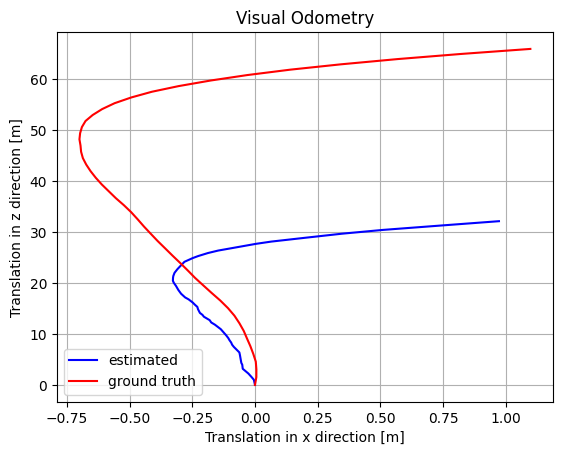

In [86]:
# Set random seed
np.random.seed(2)
torch.cuda.manual_seed(2)
torch.manual_seed(2)



# Create KITTI dataloader
sequence="02"
dataloader = KITTI(
    data_path="/home/starfleeet/Documents/project/mvo_dataset/dataset/sequences",
    pose_path="/home/starfleeet/Documents/project/mvo_dataset/dataset/poses",
    sequence=sequence,
)
dataloader.read_intrinsics_param()



display_traj = False
optimize=True

# Create camera model object
cam = CameraModel(params=dataloader.cam_params)

# Create network model to estimate depth
# depth_model = DepthModel(model_type="dpt_hybrid_kitti")



# Initialize VO with camera model and depth model
vo = VisualOdometry(cam, depth_model=None)

# Initialize graph trajectory
trajectory = 255 + np.zeros((700, 700, 3), dtype=np.uint8)

# Initialize lists
estimated_trajectory = []
gt_trajectory = []
poses = []

for _ in tqdm(
    range((len(dataloader)//90)), desc="Sequence {}: ".format(sequence)):
    # Get frame, ground truth pose and frame_id from dataset
    frame, pose, frame_id = dataloader.get_next_data()

    # Apply VO motion estimation algorithm
    vo.update(frame, frame_id)

    # Get estimated translation
    estimated_t = vo.t.flatten()
    [x, y, z] = estimated_t
    [x_true, y_true, z_true] = [pose[0], pose[1], pose[2]]

    # Store all estimated poses (4x4)
    poses.append(vo.pose)

    # Store trajectories
    estimated_trajectory.append(estimated_t)
    gt_trajectory.append(pose)

    # Draw trajectory
    if display_traj:
        cv2.circle(
            trajectory, (int(x) + 350, int(-z) + 610),
            1, (255, 0, 0),
            1)
        cv2.circle(
            trajectory, (int(x_true) + 350, int(-z_true) + 610),
            1, (0, 0, 255),
            2)
        cv2.rectangle(trajectory, (10, 20), (600, 81),
                      (255, 255, 255), -1)  # background to display MSE
        cv2.putText(trajectory, "Ground truth (RED)", (20, 40),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 255), 1, 8)
        cv2.putText(trajectory, "Estimated (BLUE)", (20, 60),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 0, 0), 1, 8)
        # compute and display distance
        MSE = np.linalg.norm(np.array([x, z]) - np.array([x_true, z_true]))
        cv2.putText(trajectory, "Frobenius Norm: {:.2f}".format(
            MSE), (20, 80), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1, 8)

        cv2.imshow("Camera", frame)
        cv2.imshow("Visual Odometry", trajectory)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Save predicted poses
save_trajectory(poses, sequence, save_dir="results")

# Save image map
if display_traj:
    cv2.imshow("results/maps/map_{}.png".format(sequence), trajectory)

# Plot estimated trajectory
plot_trajectory(gt_trajectory, estimated_trajectory, save_name="results/plots/plot_{}.png".format(sequence))

### Evaluation and quantitative comparision